In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pylab as plt

from io import StringIO
from datetime import date

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = (15,6)
%matplotlib inline

In [3]:
df_fx_data = pd.read_csv('Datasets/BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
...,...,...
10832,1975-01-08,0.7554
10833,1975-01-07,0.7510
10834,1975-01-06,0.7524
10835,1975-01-03,0.7585


In [4]:
df_fx_data.dtypes

Date      object
Value    float64
dtype: object

In [5]:
df_fx_data.shape

(10837, 2)

In [6]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])

In [7]:
indexed_df = df_fx_data.set_index('Date')
indexed_df.head()

,Value
Date,
2017-11-09,0.8603
2017-11-08,0.8631
2017-11-07,0.8639
2017-11-06,0.8631
2017-11-03,0.8608


In [8]:
ts = indexed_df['Value']
ts.head(10)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
2017-11-02    0.8567
2017-11-01    0.8608
2017-10-31    0.8584
2017-10-30    0.8601
2017-10-27    0.8635
Name: Value, dtype: float64

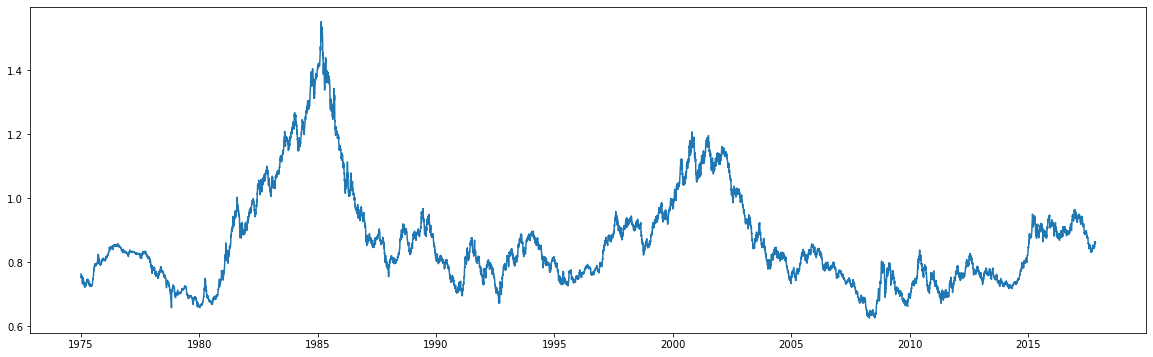

In [9]:
plt.figure(figsize=(20,6))
plt.plot(ts)
plt.show()

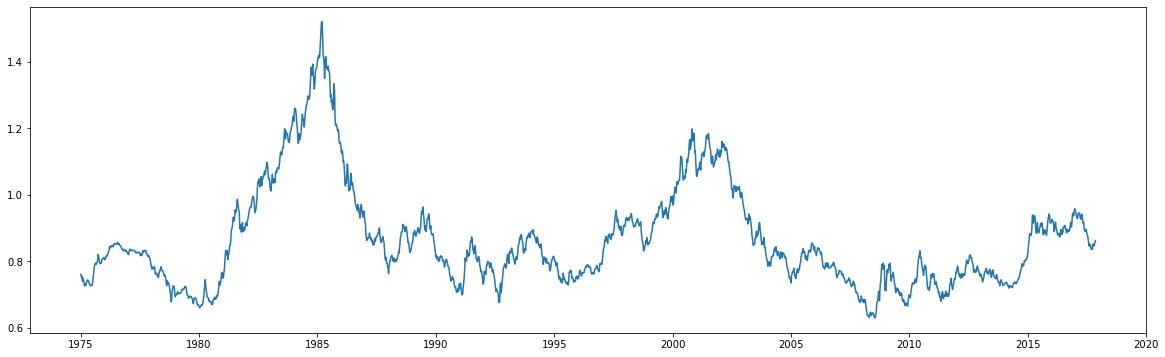

In [10]:
plt.figure(figsize=(20,6))
ts_week = ts.resample('W').mean()
plt.plot(ts_week)
plt.show()

In [11]:
ts_week.head(10)

Date
1975-01-05    0.76090
1975-01-12    0.75346
1975-01-19    0.75546
1975-01-26    0.74388
1975-02-02    0.73902
1975-02-09    0.74906
1975-02-16    0.74142
1975-02-23    0.73538
1975-03-02    0.72578
1975-03-09    0.72668
Freq: W-SUN, Name: Value, dtype: float64

In [12]:
def test_stationarity(timeseries):
    # Determining Rolling Stats
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    # Plot Rolling Stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.show(block=False)
    print("Results of Dickey-Fuller Test:\n")
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'P-value', '# Lags Used', 'Number of Observations'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

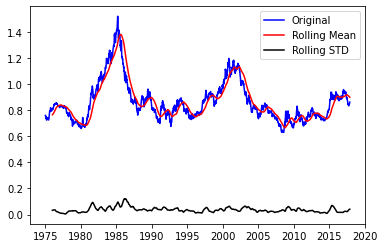

Results of Dickey-Fuller Test:

Test Statistic              -2.076341
P-value                      0.254134
# Lags Used                  2.000000
Number of Observations    2234.000000
Critical Value (1%)         -3.433281
Critical Value (5%)         -2.862835
Critical Value (10%)        -2.567459
dtype: float64


In [13]:
test_stationarity(ts_week)

`NOTE` : Because the test statistic is more than the 5% critical value and the p
value is larger than 0.05, the moving
average is not constant over time and the null hypothesis of the Dickey Fuller test cannot be rejected. This
shows that the weekly time series is not stationary

In [14]:
ts_week_log = np.log(ts_week)

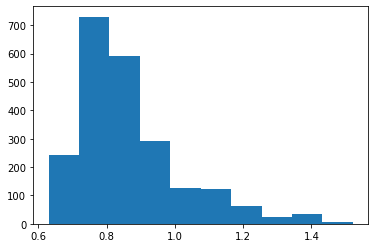

In [15]:
plt.hist(ts_week)
plt.show()

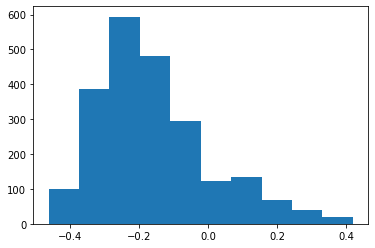

In [16]:
plt.hist(ts_week_log)
plt.show()

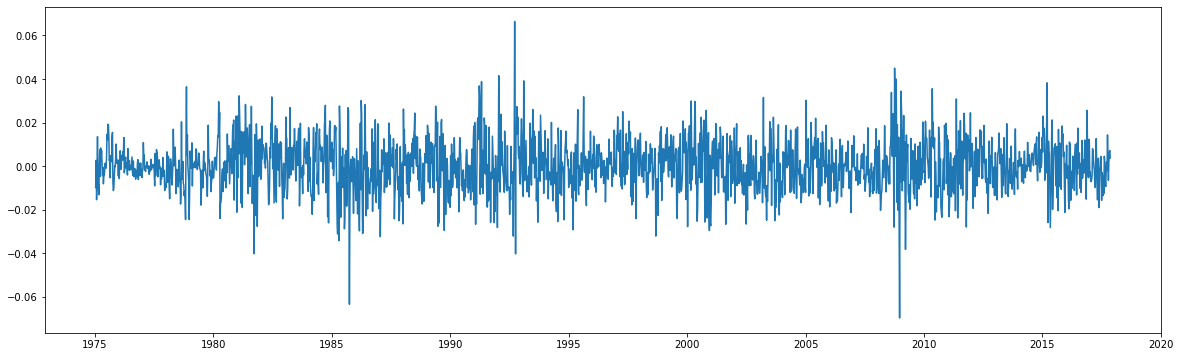

In [17]:
plt.figure(figsize=(20,6))
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)
plt.show()

Hence, Period by Default in the Shift above is 1, then d=1

In [18]:
ts_week_log_diff.head()

Date
1975-01-05         NaN
1975-01-12   -0.009826
1975-01-19    0.002651
1975-01-26   -0.015447
1975-02-02   -0.006555
Freq: W-SUN, Name: Value, dtype: float64

In [19]:
ts_week_log_diff.shape

(2237,)

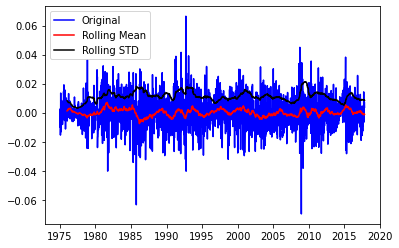

Results of Dickey-Fuller Test:

Test Statistic             -36.590004
P-value                      0.000000
# Lags Used                  0.000000
Number of Observations    2235.000000
Critical Value (1%)         -3.433279
Critical Value (5%)         -2.862834
Critical Value (10%)        -2.567459
dtype: float64


In [20]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

`NOTE` : The test statistic is significantly less than the 1% critical value, shows that your time series is now stationary with
99% confidence. Now you can begin to apply statistical models like ARIMA to forecast future Euro exchange
rates using this stationarized time series

### ACF and PACF

In [21]:
lag_acf = acf(ts_week_log_diff, nlags=20)
lag_pacf = pacf(ts_week_log_diff, nlags=20, method='ols')

In [22]:
lag_acf

array([ 1.        ,  0.25046862,  0.03934399,  0.02220274,  0.02007253,
        0.00431513, -0.01417335, -0.00714647,  0.02560459,  0.00680146,
        0.00221343,  0.0332745 ,  0.01471063,  0.01692689,  0.02797282,
        0.02230493, -0.00836548,  0.00846803, -0.00586896,  0.00557443,
        0.01010628])

In [23]:
lag_pacf

array([ 1.00000000e+00,  2.50480164e-01, -2.49855551e-02,  1.97666980e-02,
        1.13651315e-02, -4.10767772e-03, -1.53735795e-02, -1.58367420e-06,
        2.93664329e-02, -7.00481267e-03,  2.56625069e-03,  3.40111046e-02,
       -3.49682205e-03,  1.43543876e-02,  2.16952702e-02,  9.73315182e-03,
       -1.92456031e-02,  1.62705586e-02, -1.28216891e-02,  8.96495653e-03,
        8.02119131e-03])

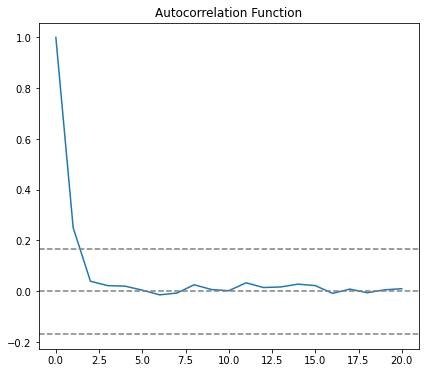

In [24]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

`Note` : The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=1

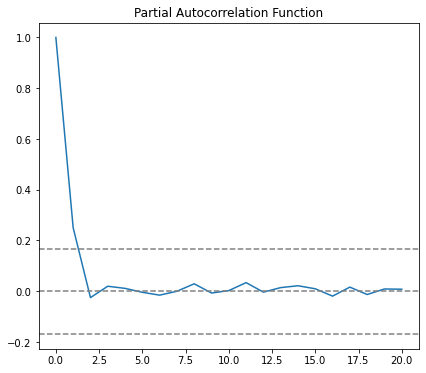

In [25]:
plt.figure(figsize=(15, 6))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

`Note` : The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=2

#### Order of ARIMA(2,1,1)

In [26]:
model = ARIMA(ts_week_log, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)

Text(0.5, 1.0, 'RSS: 0.2805846546806904')

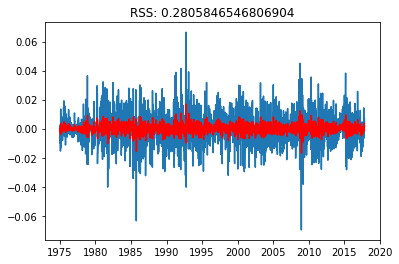

In [27]:
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(f"RSS: {sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2)}")

In [28]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 04 May 2021   AIC                         -13731.202
Time:                        11:07:18   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

### Plot Residual Errors

                 0
count  2236.000000
mean      0.000001
std       0.011205
min      -0.061306
25%      -0.006725
50%      -0.000228
75%       0.006869
max       0.064140


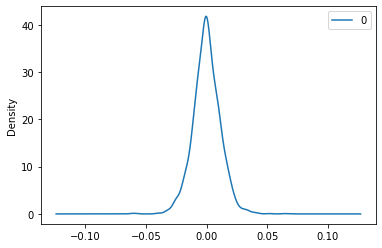

In [29]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

`NOTE` : A residual plot centered around 0 indicates good model

In [30]:
results_ARIMA.forecast(2)

(array([-0.14695356, -0.14674697]),
 array([0.01120189, 0.01799704]),
 array([[-0.16890886, -0.12499826],
        [-0.18202053, -0.11147342]]))

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE: 0.1353')

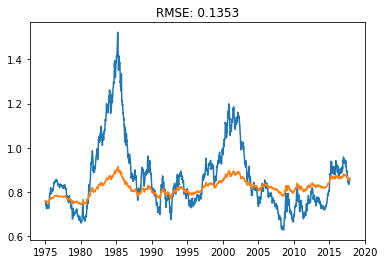

In [32]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title(f'RMSE: {np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)):.4f}')

`NOTE` : The RMSE is close enough to 0: the model predictions are accurate.

### Train-Test Split

In [33]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[:size], ts_week_log[size:]
history = [x for x in train]

In [34]:
ts_week_log.shape

(2237,)

In [35]:
train.shape

(2222,)

In [36]:
test.shape

(15,)

In [37]:
predictions = list()
print('Printing Predicted vs Expected Values...\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print(f"Predicted = {np.exp(yhat)[0]} | Expected = {np.exp(obs)}")    

Printing Predicted vs Expected Values...

Predicted = 0.8608527265508911 | Expected = 0.8625999999999999


In [38]:
error = mean_squared_error(test, predictions)
print(f"Test Mean Squared Error for Predictions..\n")
print(f"{error:.6f}")

Test Mean Squared Error for Predictions..

0.000043


In [39]:
prediction_series = pd.Series(predictions, index = test.index)

In [40]:
rcParams['figure.figsize'] = (20,6)

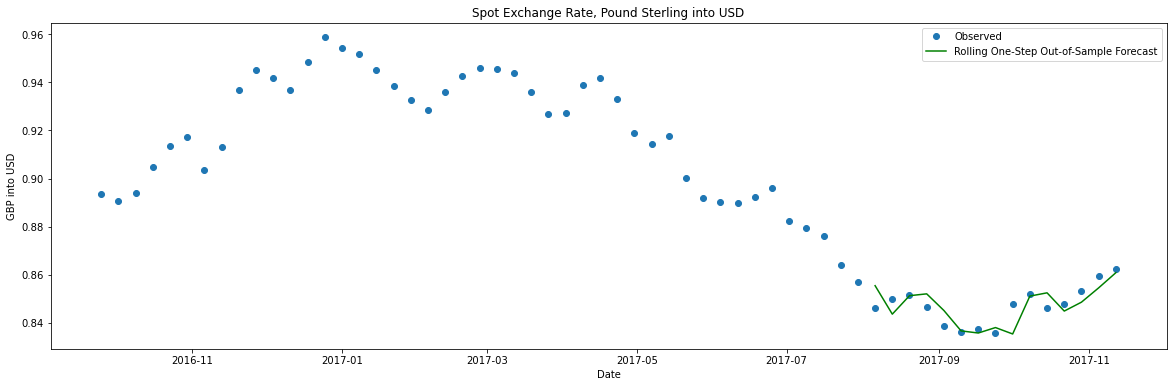

In [41]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Pound Sterling into USD', xlabel='Date', ylabel='GBP into USD')
ax.plot(ts_week[-60:], 'o', label='Observed')
ax.plot(np.exp(prediction_series), 'g', label='Rolling One-Step Out-of-Sample Forecast')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')
plt.show()